In [2]:
import os
import sys
import math
import glob
import pickle
import random
import numpy as np
import pandas as pd
from Bio.PDB import *
from Bio.PDB.Selection import unfold_entities
from Bio.PDB.NeighborSearch import NeighborSearch
import statistics as st

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn import linear_model
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 20})
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sb.set(font_scale = 1.8)
sb.set_style("whitegrid")

def load_resfile(file):
    res = {}
    for line in open(bsfolder+'results/'+file):
        code = line.split()[-1].split('/')[-1].split('_')[0]
        dockq = float(line.split()[1])
        if not code in res: res[code] = []
        res[code].append(dockq)
    return res

bsfolder = '/home/gabriele/Desktop/BindingSite_docking/'
codelist = [line.rstrip() for line in open(bsfolder+'list_dimers')]
codesb4only = [line.rstrip() for line in open(bsfolder+'b4_only')]
codesb5only = [line.rstrip() for line in open(bsfolder+'b5_only')]
chainlist = []
for code in codelist:
    chainlist.append(code+'_u1')
    chainlist.append(code+'_u2')

tags = ['BIP1', 'BIP2', 'ISP_SVM', 'ISP_CRF',
        'PRE', 'JET_CL', 'JET_TR', 'SPP']

postag = {1:'realb',
          12:'BIP2', 13:'ISP_SVM', 15:'PRE', 
          16:'JET_CL', 17:'JET_TR', 18:'SPP'}

tagpos = {tag:n for n, tag in enumerate(tags)}

dockqs = {'base':load_resfile('res_dockbase'), 'aace':load_resfile('res_dockaace'),
          'realb':load_resfile('res_dock1'),
          'r1075':load_resfile('res_dock2'), 'r105':load_resfile('res_dock3'),
          'r1025':load_resfile('res_dock4'),'r0751':load_resfile('res_dock5'), 
          'r051':load_resfile('res_dock6'), 'r0251':load_resfile('res_dock7'),
          'r0505':load_resfile('res_dock8'), 'r05025':load_resfile('res_dock9'), 
          'r02505':load_resfile('res_dock10'),
          'BIP1':load_resfile('res_dock11'), 'BIP2':load_resfile('res_dock12'),
          'ISP_SVM':load_resfile('res_dock13'), 'ISP_CRF':load_resfile('res_dock14'),
          'PRE':load_resfile('res_dock15'),
          'JET_CL':load_resfile('res_dock16'), 'JET_TR':load_resfile('res_dock17'),
          'SPP':load_resfile('res_dock18')}

name_refine = {
    'base':'Gramm Baseline',
    'aace':'Gramm+AACE18',
    'realb':'Real Interface',
    'r1075':'TPR1.0-PPV0.75', 
    'r105':'TPR1.0-PPV0.5', 
    'r1025':'TPR1.0-PPV0.25', 
    'r0751':'TPR0.75-PPV1.0', 
    'r051':'TPR0.5-PPV1.0', 
    'r0251':'TPR0.25-PPV1.0', 
    'r0505':'TPR0.5-PPV0.5', 
    'r05025':'TPR0.5-PPV0.25', 
    'r02505':'TPR0.25-PPV0.5',
    'ISP_SVM':'ISPRED4',
    'ISP_CRF':'ISPRED4 CRF',
    'BIP1':'BIPSPI 1',
    'BIP2':'BIPSPI',
    'PRE':'PREDUS',
    'JET_CL':'dynJET Cluster',
    'JET_TR':'dynJET Trace',
    'SPP':'SPPIDER'}

palette1 = ['#ff7f00', '#377eb8']
palette2 = ['#007b04','#aa3fff','#c79a00', '#00d8ff']
palette3 = ['#895dca', #Purple
            '#5ddcde', #Cyan
            '#cb5838', #Bordoux
            '#539c56', #Darkgreen
            '#a3c85d', #Lightgreen
            '#c79a00'] #Orange
            
palette4 = ['#5b80ff', '#c79a00']
palette5 = ['#e5e5e5', #White
            '#56ce96', #Waterygreen
            '#895dca', #Purple
            '#5ddcde', #Cyan
            '#539c56', #Darkgreen
            '#a3c85d', #Lightgreen
            '#cb5838', #Bordoux
            '#c79a00'] #Orange

In [3]:
for code in dockqs['realb']:
    if max(dockqs['realb'][code][:10]) < 0.23:
        print (code, max(dockqs['realb'][code][:10]))

1gcq 0.19
1ib1 0.152
1jiw 0.18
1k5g 0.201
1kgy 0.094
1lb2 0.202
1lfd 0.197
1nql 0.128
1r8s 0.147
1uad 0.128
1wrd 0.116
1y64 0.17
1y8x 0.174
2abz 0.165
2aq3 0.085
2c0l 0.202
2ch4 0.098
2i25 0.114
2ido 0.105
2nxn 0.089
2uy7 0.115
2vrr 0.132
2xwb 0.206
3av0 0.224
3cw2 0.012
3f1p 0.179
3fpu 0.084
3k1i 0.102
3l4q 0.117
3oun 0.172
3t5g 0.225
3znz 0.122
4c0o 0.067
4c6t 0.157
4ct4 0.194
4etw 0.101
4f7g 0.132
4ilh 0.188
4lsx 0.073
4o4b 0.119
4x6q 0.11
4xoi 0.157


In [4]:
##### DOCKING DIFFICULTY #####
def get_int(ch, opp):
    oppatoms = [atom for res in opp for atom in res]
    ns = NeighborSearch(oppatoms)
    
    intids = []
    for res in ch: 
        for atom in res:
            center = atom.get_coord()
            neighbors = ns.search(center, 6, 'R')
            if len(neighbors) != 0:
                intids.append(res.get_id()[1])
                break
    return intids

def get_contacts(strA,strB):
    contacts = []
    atomsA = [atom for res in strA for atom in res]
    atomsB = [atom for res in strB for atom in res]
    
    ns = NeighborSearch(atomsB)
    for res in strA:
        resnumA = res.get_id()[1]
        for atom in res: 
            atom = atom.get_coord()
            nlist = ns.search(atom, 5, 'R')
            for res in nlist:
                resnumB = res.get_id()[1]
                contact = str(resnumA)+'_'+str(resnumB)
                if contact not in contacts:
                    contacts.append(contact)
    
    ns = NeighborSearch(atomsA)
    for res in strB:
        nlist = []
        resnumB = res.get_id()[1]
        for atom in res: 
            atom = atom.get_coord()
            nlist = ns.search(atom, 5, 'R')
            for res in nlist:
                resnumA = res.get_id()[1]
                contact = str(resnumA)+'_'+str(resnumB)
                if contact not in contacts:
                    contacts.append(contact)
    return contacts                 

lengths = {}
hardness = {}
interfaces = {}
h = m = e = 0
p = PDBParser(QUIET=True)
for code in codelist: 
    unbound = bsfolder+'data/processed_b4/'+code+'_uc.pdb'
    bound = bsfolder+'data/processed_b4/'+code+'_bc.pdb'
    ustr = p.get_structure('', unbound)
    bstr = p.get_structure('', bound)
    uresA = unfold_entities(ustr[0]['A'], 'R')
    uresB = unfold_entities(ustr[0]['B'], 'R')
    bresA = unfold_entities(bstr[0]['A'], 'R')
    bresB = unfold_entities(bstr[0]['B'], 'R')
    lengths[code] = [len(bresA), len(bresB)]
    bintA = get_int(bresA, bresB)
    bintB = get_int(bresB, bresA)
    interfaces[code] = [len(bintA), len(bintB)]
    
    acc = 0
    for rid in bintA:
        bcarb = ucarb = ''
        if 'CA' in bstr[0]['A'][rid]:
            bcarb = bstr[0]['A'][rid]['CA']
        if 'CA' in ustr[0]['A'][rid]:
            ucarb = ustr[0]['A'][rid]['CA']
        if bcarb != '' and ucarb != '': 
            acc += (bcarb-ucarb)
        
    for rid in bintB:
        bcarb = ucarb = ''
        if 'CA' in bstr[0]['B'][rid]:
            bcarb = bstr[0]['B'][rid]['CA']
        if 'CA' in ustr[0]['B'][rid]:
            ucarb = ustr[0]['B'][rid]['CA']
        if bcarb != '' and ucarb != '':
            acc += (bcarb-ucarb)
            
    iRMSD = acc/(len(bintA)+len(bintB))
    
    if iRMSD > 2.2:
        hardness[code] = ['H', iRMSD, None]
    elif iRMSD > 1.5:
        hardness[code] = ['M', iRMSD, None]
    else:
        bresA = [bstr[0]['A'][rid] for rid in bintA]
        bresB = [bstr[0]['B'][rid] for rid in bintB]
        contb = set(get_contacts(bresA,bresB))
        uintA = get_int(uresA, uresB)
        uintB = get_int(uresB, uresA)
        uresA = [ustr[0]['A'][rid] for rid in uintA]
        uresB = [ustr[0]['B'][rid] for rid in uintB]
        contu = set(get_contacts(uresA,uresB))
        conserved = contb.intersection(contu)
        nonnat = len(contu)-len(conserved)
        F_nonnat = nonnat/len(contu)
        if F_nonnat < 0.4:
            hardness[code] = ['E', iRMSD, F_nonnat]
        else: 
            hardness[code] = ['M', iRMSD, F_nonnat]
            
h = m = e = 0
hard = []
medium = []
rigid_body = []
for key in hardness:
    if hardness[key][0] == 'H': 
        h += 1
        hard.append(key)
    elif hardness[key][0] == 'M': 
        m += 1
        medium.append(key)
    else: 
        e += 1
        rigid_body.append(key)
        
print ('Whole dataset\n'
       'Hard targets:{}\n'
       'Medium targets:{}\n'
       'Rigid-Body targets:{}\n\n'.format(h,m,e))

h = m = e = 0
method_fail = []
for key in dockqs['realb']: 
    if max(dockqs['realb'][key][:10])<0.23:
        method_fail.append(key)
        if hardness[key][0] == 'H': h += 1
        elif hardness[key][0] == 'M': m += 1
        else: e += 1
        
print ('Real interface docking fails (Top10)\n'
       'Hard targets:{}\n'
       'Medium targets:{}\n'
       'Rigid-Body targets:{}\n\n'.format(h,m,e))

Whole dataset
Hard targets:39
Medium targets:67
Rigid-Body targets:113


Real interface docking fails (Top10)
Hard targets:21
Medium targets:13
Rigid-Body targets:8




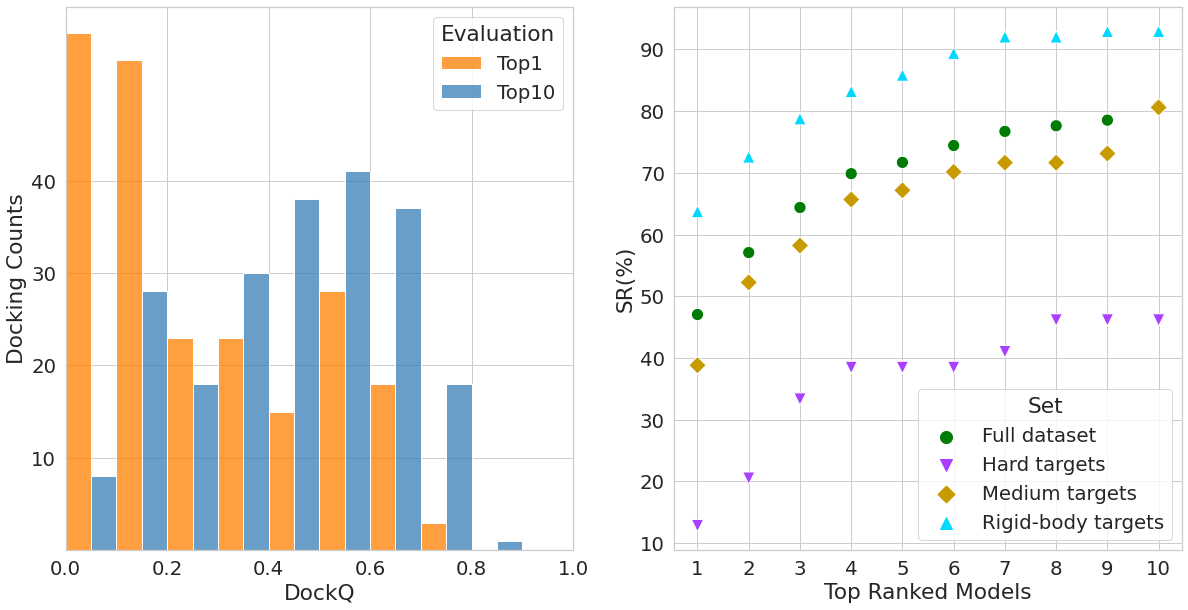

In [5]:
def get_firstmodel(key, lbl):
    results = [dockqs[key1][key][0] for key in dockqs[key1]]    
    return [results[key] for key in results]

def success_rate(label, allowed, succ_rates):
    succ_rates['TargetSet'] += [label]*10
    succ_rates['TopMod.'] += list(range(1,11))
    for top in range(1,11):
        res = {key:max(dockqs['realb'][key][:top])\
                for key in dockqs['realb']\
                if key in allowed}
        success = [1 if res[key] >= 0.23 else 0 for key in res]
        succ_rates['SR(%)'].append((sum(success)/len(success))*100)
    return succ_rates

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

results = [dockqs['realb'][key][0]\
           for key in dockqs['realb']]
results += [max(dockqs['realb'][key][:10])\
            for key in dockqs['realb']]

labels = ['Top1' for n in dockqs['realb']]
labels += ['Top10' for n in dockqs['realb']]

data = {'DockQ':results, 'Evaluation':labels}
data = pd.DataFrame(data)

sb.set_palette(palette=palette1)
sb.histplot(x='DockQ', data=data, hue='Evaluation', 
            kde=False, bins=np.arange(0.0, 1.025, 0.1), 
            multiple='dodge', ax=axes[0])

axes[0].set_xlabel("DockQ")
axes[0].set_ylabel("Docking Counts")
axes[0].set_yticks(np.arange(10,41,10))
axes[0].set_xlim(0,1)

succ_rates = {'SR(%)':[], 'TopMod.':[], 'TargetSet':[]}
succ_rates = success_rate('Full dataset', codelist, succ_rates)
succ_rates = success_rate('Hard targets', hard, succ_rates)
succ_rates = success_rate('Medium targets', medium, succ_rates)
succ_rates = success_rate('Rigid-body targets', rigid_body, succ_rates)

succ_rates = pd.DataFrame(succ_rates)
sb.set_palette(palette=palette2)
sb.scatterplot(x='TopMod.', y='SR(%)', hue='TargetSet',
               style='TargetSet', data=succ_rates, s=150,
               markers=['o', 'v', 'D', '^'], ax=axes[1])

axes[1].set_ylabel("SR(%)")
axes[1].set_xlabel("Top Ranked Models")
axes[1].set_xticks(np.arange(1,11))
axes[1].legend(title='Set', markerscale=2)
fig.savefig(bsfolder+'pictures/gramm_realinterface.png')
plt.show()

BIP2
Worst AUC 0.31625789138740573 Baseline 0.20674548966037024
Non-random prediction chains: 365
0.4873523293817765
ISP_SVM
Worst AUC 0.19233786359701274 Baseline 0.2274214489742924
Non-random prediction chains: 316
0.2899735102994424
PRE
Non-random prediction chains: 301
JET_CL
Worst AUC 0.22291776809462782 Baseline 0.22078053213510376
Non-random prediction chains: 295
0.30272714212939256
JET_TR
Worst AUC 0.17883029481795124 Baseline 0.22771407912405744
Non-random prediction chains: 302
0.26558324957503154
SPP
Worst AUC 0.2394067007933488 Baseline 0.22470751945575426
Non-random prediction chains: 346
0.32408828637540676


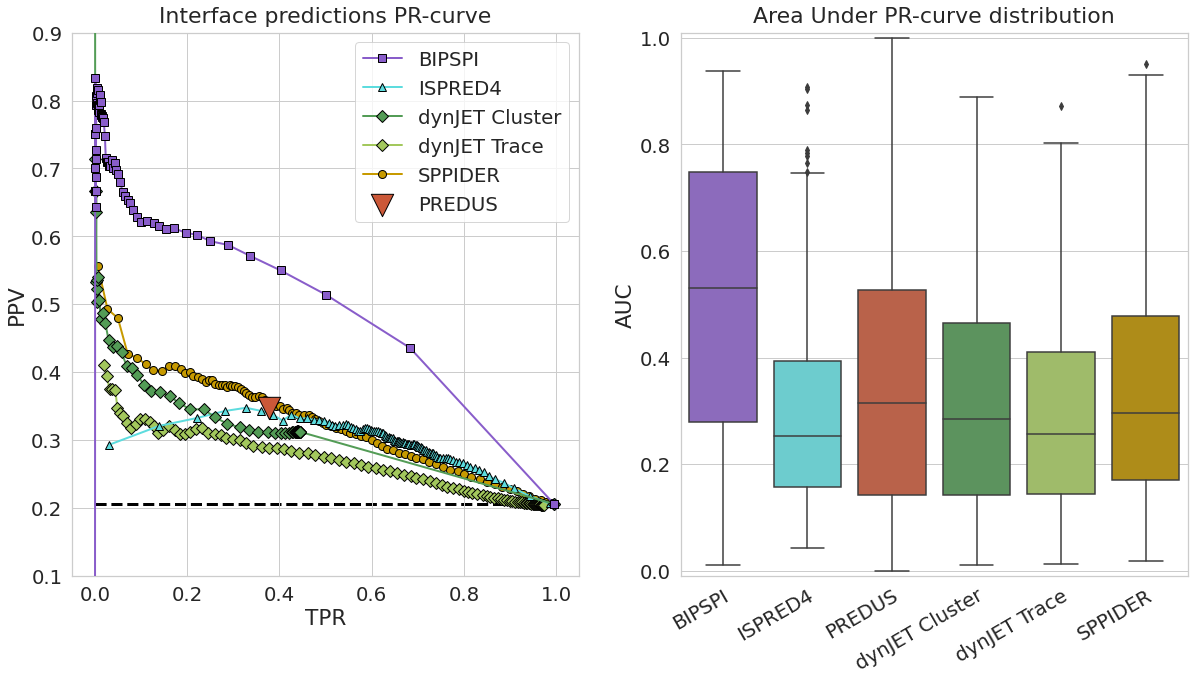

In [6]:
sb.set_palette(palette=palette3)
def manual_pr_stats(scores, allscores):
    TPR = []
    PPV = []
    
    array = np.array(scores)
    thresholds = np.array(allscores)    
    array = array[array[:,1].argsort()[::-1]]
    thresholds = thresholds[thresholds.argsort()[::-1]]
    
    for thr in thresholds:
        TP = FP = FN = TN = 0
        for pair in array: 
            if pair[0] >= thr: 
                if pair[1] == 1.0: TP += 1
                else: FP += 1
            else:
                if pair[1] == 1.0: FN += 1
                else: TN += 1
        if TP+FP==0:
            TPR.append(TP/(TP+FN))
            PPV.append(2.0)
            continue
        TPR.append(TP/(TP+FN))
        PPV.append(TP/(TP+FP))
    return {'TPR':TPR, 'PPV':PPV}      

def avg_curves(stats):
    stats['TPR'] = np.array(stats['TPR'])
    stats['PPV'] = np.array(stats['PPV'])
    stats['TPR'] = np.sum(stats['TPR'], axis=0)/440

    PPVs = []
    for x in range(len(stats['PPV'][0])):
        acc = 0
        count = 0
        for y in range(len(stats['PPV'])):
            if stats['PPV'][y][x] != 2.0:
                acc += stats['PPV'][y][x]
                count += 1
        if count > 0: PPVs.append(acc/count)
        else: stats['TPR'] = stats['TPR'][1:]
    stats['PPV'] = PPVs
    return stats

def BSpred_stats(n,  label):
    print (label)
    statsmap = {}
    surfaces = {}
    allscores = []
    chainscores1 = []
    chainscores2 = []
    nonrandcount = 0
    worstcount = 0
    worstbase = 0
    ##### iterate over all dataset to find all possible thresholds
    for code in chainlist:
        labelfile = bsfolder+'data/formatted_labels/'+code+'.site'
        isp = [float(line.split()[n]) if line.split()[n] != '1.0'
               else 0.99 for line in open(labelfile)]
        rsa = [float(line.split()[0]) for line in open(labelfile)]
        for lp, acc in zip(isp, rsa):
            if acc < 0.2: continue
            allscores.append(lp)
    allscores = list(set(allscores))
    
    ##### iterate again to calculate stats
    allstats = {'PPV':[], 'TPR':[]}
    worststats = {'PPV':[], 'TPR':[]}
    for code in chainlist:
        pdbcode = code[:4]
        labelfile = bsfolder+'data/formatted_labels/'+code+'.site'
        isp = [float(line.split()[n]) if line.split()[n] != '1.0'
               else 0.99 for line in open(labelfile)]
        ist = [float(line.split()[1]) for line in open(labelfile)]
        rsa = [float(line.split()[0]) for line in open(labelfile)]
        if pdbcode not in surfaces: 
            surfaces[pdbcode] = [sum([1 for line in open(labelfile) if float(line.split()[0]) > 0.2])]
        else: 
            surfaces[pdbcode].append(sum([1 for line in open(labelfile) if float(line.split()[0]) > 0.2]))
        for lp, lt, acc in zip(isp, ist, rsa):
            if acc < 0.2: continue
            if '_u1' in code: chainscores1.append([lp, lt])
            else: chainscores2.append([lp, lt])

        if '_u2' in code:
            ##### proportion of interface residues
            base1 = np.sum(np.array(chainscores1)[:,1])/len(chainscores1)
            base2 = np.sum(np.array(chainscores2)[:,1])/len(chainscores2)
            
            ##### calculate single protein stats (chain1) and remove missing PPV points
            refstats1 = {}
            stats1 = manual_pr_stats(chainscores1, allscores)
            if stats1['PPV'][0] == 2.0:
                for i, ppv in enumerate(stats1['PPV']):
                    if ppv != 2.0:
                        refstats1['TPR'] = stats1['TPR'][i:]
                        refstats1['PPV'] = stats1['PPV'][i:]
                        break
            else: 
                refstats1['TPR'] = stats1['TPR']
                refstats1['PPV'] = stats1['PPV']
            
            ##### calculate single protein stats (chain2) and remove missing PPV points
            refstats2 = {}
            stats2 = manual_pr_stats(chainscores2, allscores)
            if stats2['PPV'][0] == 2.0:
                for i, ppv in enumerate(stats2['PPV']):
                    if ppv != 2.0:
                        refstats2['TPR'] = stats2['TPR'][i:]
                        refstats2['PPV'] = stats2['PPV'][i:]
                        break
            else: 
                refstats2['TPR'] = stats2['TPR']
                refstats2['PPV'] = stats2['PPV']
            
            ##### complexes with no prediction different from 0 are given constant PPV between 1 and 0 TPR
            if len(refstats1['PPV']) <= 2:
                refstats1['TPR'] = [0.0]+refstats1['TPR']
                refstats1['PPV'] = refstats1['PPV']*2
            if len(refstats2['PPV']) <= 2:
                refstats2['TPR'] = [0.0]+refstats2['TPR']
                refstats2['PPV'] = refstats2['PPV']*2
            
            ##### calculate AUC for single chains, save individual chain AUCs, 
            ##### compare to chain random prediction baseline and gather worst AUC 
            ##### generating chains to do a dataset-wide average of those chains only
            statsmap[pdbcode] = {}
            if label != 'PRE':
                auc1 = auc(refstats1['TPR'], refstats1['PPV'])
                auc2 = auc(refstats2['TPR'], refstats2['PPV'])
                statsmap[pdbcode]['PR-AUC'] = [auc1, auc2]
                if auc1 > base1: nonrandcount += 1
                if auc2 > base2: nonrandcount += 1
                if auc1 > auc2:
                    worststats['TPR'].append(stats1['TPR'])
                    worststats['PPV'].append(stats1['PPV'])
                    worstcount += len(chainscores1)
                    worstbase += np.sum(np.array(chainscores1)[:,1])
                else:   
                    worststats['TPR'].append(stats2['TPR'])
                    worststats['PPV'].append(stats2['PPV'])
                    worstcount += len(chainscores2)
                    worstbase += np.sum(np.array(chainscores2)[:,1])
            ##### compare PPV instead in case of PREDUS
            else:
                if refstats1['PPV'][0] > base1: nonrandcount += 1
                if refstats2['PPV'][0] > base2: nonrandcount += 1
            
            ##### save individual chains PPV
            statsmap[pdbcode]['PPVs'] = [refstats1['PPV'][0], refstats2['PPV'][0]]
            statsmap[pdbcode]['scores'] = []
            statsmap[pdbcode]['scores'].append(np.array(chainscores1))
            statsmap[pdbcode]['scores'].append(np.array(chainscores2))
            
            ##### stack dataset wide statistics  
            allstats['TPR'].append(stats1['TPR'])
            allstats['TPR'].append(stats2['TPR'])
            allstats['PPV'].append(stats1['PPV'])
            allstats['PPV'].append(stats2['PPV'])
            chainscores1 = []
            chainscores2 = []
    
    ##### calculate average points for PR-curves
    allstats = avg_curves(allstats)
    if label != 'PRE':
        worststats = avg_curves(worststats)
        print ('Worst AUC', auc(worststats['TPR'], worststats['PPV']), 'Baseline', worstbase/worstcount)     
    print ('Non-random prediction chains:', nonrandcount)
    
    return allstats, statsmap, surfaces


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
j = 0
ms = 8
ds = 500
points = {}
metricdic = {}
aucs = {'AUC':[], 'Method':[]}
ordermap = {'BIP1':6, 'BIP2':7, 'ISP_SVM':3, 
            'ISP_CRF':8, 'PRE':5, 'JET_CL':4, 
            'JET_TR':2, 'SPP':1}
markermap = {'BIP1':'s', 'BIP2':'s', 'ISP_SVM':'^', 
            'ISP_CRF':'^', 'PRE':'v', 'JET_CL':'D', 
            'JET_TR':'D', 'SPP':'o'}

for n, tag in enumerate(tags):
    z = ordermap[tag]
    m = markermap[tag]
    if tag in ['BIP1', 'ISP_CRF']: continue
    allstats, mapping, surfaces = BSpred_stats(n+11, tag)
    metricdic[tag+'map'] = mapping

    if tag == 'PRE':
        for key in allstats: allstats[key] = [allstats[key][0]]
        axes[0].scatter(allstats['TPR'], allstats['PPV'], 
                        marker=m, s=ds, edgecolors='black', 
                        c='C'+str(j), zorder=z, label=name_refine[tag])
        for code in mapping:
            aucs['AUC'] += mapping[code]['PPVs']
            aucs['Method'] += [name_refine[tag]]*2
        j += 1
        continue    
        
    axes[0].plot(allstats['TPR'], allstats['PPV'], 
                 marker=m, linewidth=2, markersize=ms, mec='black', 
                 c='C'+str(j), zorder=z, label=name_refine[tag])
    print (auc(allstats['TPR'], allstats['PPV']))
    for code in mapping:
        aucs['AUC'] += mapping[code]['PR-AUC']
        aucs['Method'] += [name_refine[tag]]*2
    j += 1

axes[0].set_title('Interface predictions PR-curve', 
                  fontdict={'fontsize':22, 
                            'verticalalignment':'bottom'})
axes[0].plot([0, 1], [allstats['PPV'][-1], allstats['PPV'][-1]],
             ls="--", lw='3', zorder=0, color='black')
axes[0].set_ylabel('PPV')
axes[0].set_xlabel('TPR')
axes[0].set_ylim(0.1,0.9)
axes[0].legend(markerscale=1)

g = sb.boxplot(x='Method', y='AUC', data=aucs, ax=axes[1])
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=30, 
         ha="right", rotation_mode="anchor")
#axes[1].plot([-1, 6], [allstats['PPV'][-1], allstats['PPV'][-1]],
#             ls="--", lw='3', zorder=10, color='black')
axes[1].set_ylabel('AUC')
axes[1].set_xlim(-0.5,5.5)
axes[1].set_ylim(-0.01,1.01)
plt.subplots_adjust(wspace=0.2)
axes[1].set_title('Area Under PR-curve distribution', 
                  fontdict={'fontsize':22, 
                            'verticalalignment':'bottom'})

fig.savefig(bsfolder+'pictures/PRcurve.png', bbox_inches='tight')

Gramm Baseline&0.02&0.04&0.08&2.73&0.038&0.072&0.104&5.45\\
Gramm+AACE18&0.02&0.07&0.11&6.82&0.06&0.132&0.173&18.18\\
BIPSPI&0.04&0.1&0.14&12.73&0.081&0.169&0.195&25.45\\
ISPRED4&0.03&0.04&0.05&1.82&0.043&0.086&0.115&8.18\\
dynJET Cluster&0.02&0.04&0.07&2.73&0.029&0.065&0.094&5.0\\
dynJET Trace&0.02&0.06&0.1&5.0&0.043&0.104&0.149&11.36\\
PREDUS&0.03&0.06&0.1&4.55&0.037&0.096&0.143&10.45\\
SPPIDER&0.02&0.05&0.08&4.55&0.04&0.094&0.136&11.36\\
Real Interface&0.2&0.28&0.2&46.82&0.468&0.446&0.197&80.45\\
TPR1.0-PPV0.75&0.19&0.25&0.19&40.0&0.449&0.423&0.198&77.73\\
TPR0.75-PPV1.0&0.16&0.22&0.16&35.45&0.385&0.377&0.196&72.73\\
TPR1.0-PPV0.5&0.12&0.18&0.16&25.0&0.3&0.345&0.194&66.36\\
TPR0.5-PPV1.0&0.14&0.21&0.17&33.18&0.305&0.339&0.194&66.36\\
TPR1.0-PPV0.25&0.07&0.1&0.1&6.82&0.128&0.185&0.158&25.45\\
TPR0.25-PPV1.0&0.1&0.14&0.12&17.73&0.198&0.255&0.182&42.73\\


/home/gabriele/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[103, 177, 103, 177, 88, 171, 78, 160, 55, 146, 73, 146, 15, 56, 39, 94]


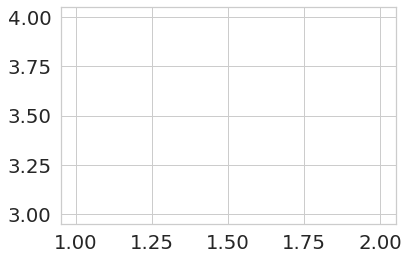

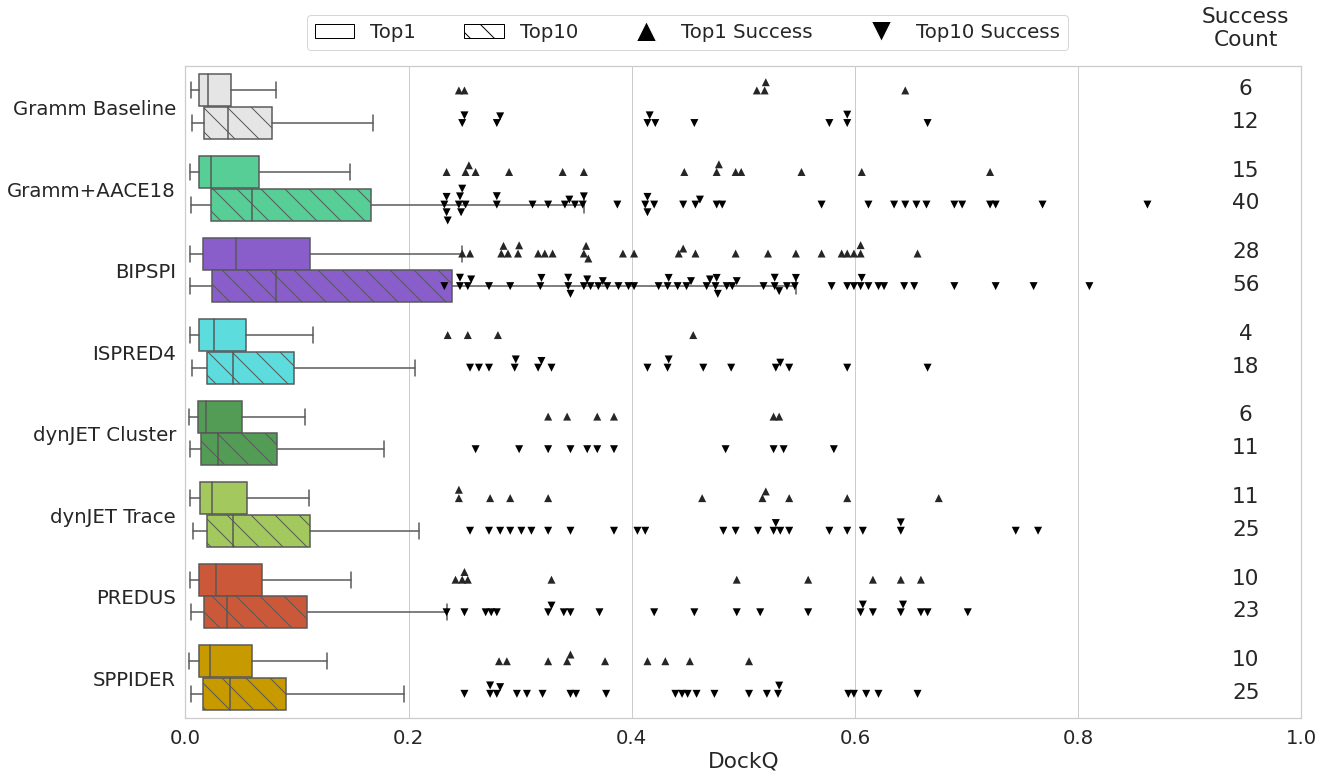

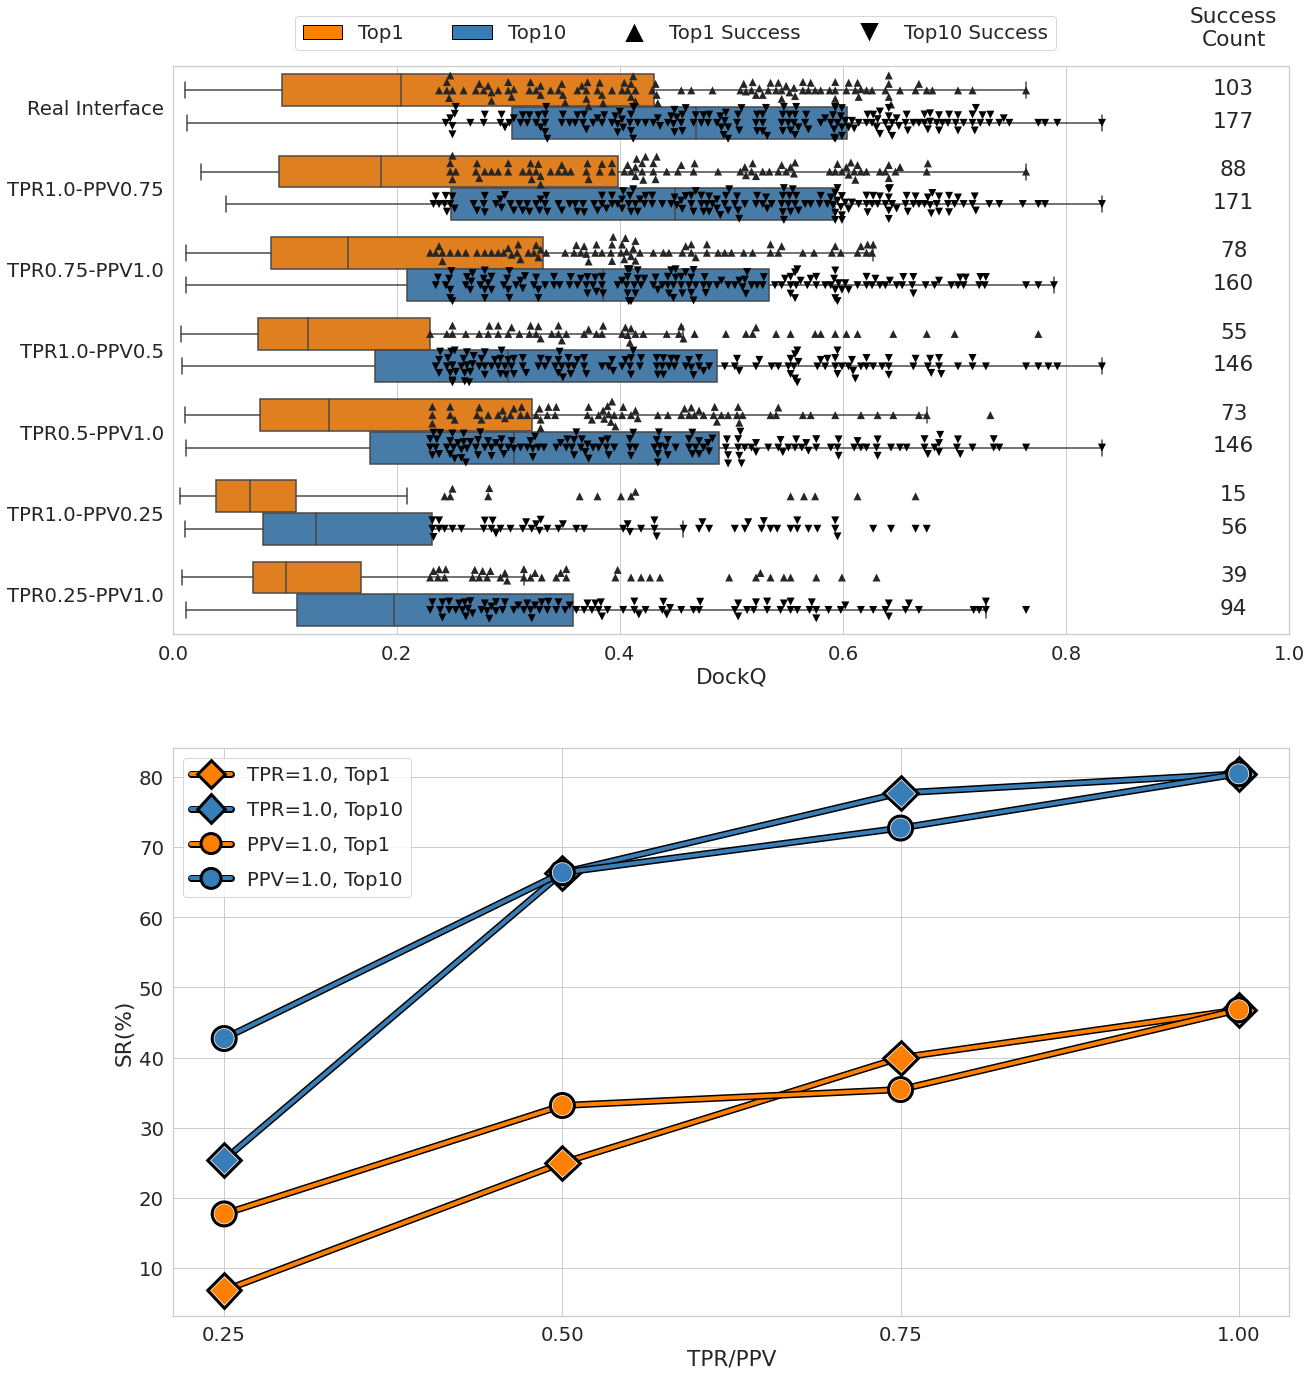

In [7]:
def compare_runs(runs):
    countdic = []
    bardic = {'DockQ':[], 'Setup':[], 'Top':[]}
    swarmdic = {'DockQ':[], 'Setup':[], 'Top':[]}
    for run in runs:
        top1dq = [dockqs[run][code][0] for code in dockqs[run]]
        top10dq = [max(dockqs[run][code][:10]) for code in dockqs[run]]
        countdic.append(len([1 for code in dockqs[run]\
                             if dockqs[run][code][0] >= 0.23]))
        top1sr = countdic[-1]/2.2
        countdic.append(len([1 for code in dockqs[run]\
                             if max(dockqs[run][code]) >= 0.23]))
        top10sr = countdic[-1]/2.2
        print ('{}&{}&{}&{}&{}&{}&{}&{}&{}\\\\'.format(name_refine[run], 
               round(st.median(top1dq), 2), round(st.mean(top1dq),2), 
               round(st.stdev(top1dq),2), round(top1sr,2),
               round(st.median(top10dq), 3), round(st.mean(top10dq),3),
               round(st.stdev(top10dq),3), round(top10sr,2)))
        for code in dockqs[run]:
            bardic['DockQ'].append(dockqs[run][code][0])
            bardic['Setup'].append(name_refine[run])
            bardic['Top'].append('Top1')
            bardic['DockQ'].append(max(dockqs[run][code]))
            bardic['Setup'].append(name_refine[run])
            bardic['Top'].append('Top10')
            if dockqs[run][code][0] >= 0.23:
                swarmdic['DockQ'].append(dockqs[run][code][0])
                swarmdic['Setup'].append(name_refine[run])
                swarmdic['Top'].append('Top1')
            if max(dockqs[run][code]) >= 0.23:
                swarmdic['DockQ'].append(max(dockqs[run][code]))
                swarmdic['Setup'].append(name_refine[run])
                swarmdic['Top'].append('Top10')
        if not name_refine[run] in swarmdic['Setup']:
            swarmdic['DockQ'].append(-1)
            swarmdic['Setup'].append(name_refine[run])
            swarmdic['Top'].append('Top1')
            swarmdic['DockQ'].append(-1)
            swarmdic['Setup'].append(name_refine[run])
            swarmdic['Top'].append('Top10')
    return bardic, swarmdic, countdic

def plot_rungroups(runs, axes):
    
    palette = palette3
    hue_order = ['Top1', 'Top10']
    sb.set_palette(palette=palette5)
    bardic, swarmdic, countdic = compare_runs(runs)
    
    if 'realb' in runs: 
        sb.set_palette(palette=palette1)
        palette = {'Top1':'C0', 'Top10':'C1' }
        
    sb.swarmplot(x='DockQ', y='Setup', hue='Top', data=swarmdic, color='Black', 
                 dodge=True, size=8, hue_order=hue_order, ax=axes)
    sb.boxplot(x='DockQ', y='Setup', data=bardic, hue='Top',
               showfliers=False, palette=palette, 
               hue_order=hue_order, ax=axes)
    axes.get_legend().remove()
    c = axes.collections
    for a in c[::2]:
        a.set_paths([tup_mk])
    for a in c[1::2]:
        a.set_paths([tdown_mk])
    
    for n, count in enumerate(countdic):
        if n%2 != 0: mod = 0.25
        else: mod = -0.15
        if n%2 != 0: n -= 1
        n /= 2
        axes.text(x=0.95, y=n+mod, s=count, ha='center')
    axes.set_xticks(np.arange(0, 1.1, 0.2))
    
    if 'BIP2' in runs:  
        colorcount = 0
        boxes = axes.findobj(matplotlib.patches.PathPatch)
        for n, box in enumerate(boxes):
            color = 'C'+str(colorcount)
            box.set_facecolor(color)
            if (n+1)%2 == 0: colorcount += 1
        
        hatches = ['', '\\']*8
        for hatch, patch in zip(hatches, axes.artists):
            patch.set_hatch(hatch)
    axes.text(x=0.95, y=-0.75, s='Success\nCount', ha='center')

    return countdic

fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='^')
b = ax.scatter([1,2],[3,4], marker='v')
tup_mk, = a.get_paths()
tdown_mk, = b.get_paths()
a.remove()
b.remove() 

fig, axes = plt.subplots(1, 1, figsize=(20, 12), sharex=True)

runs = ['base', 'aace', 'BIP2', 
        'ISP_SVM', 'JET_CL', 
        'JET_TR', 'PRE', 'SPP']

countdic = plot_rungroups(runs, axes)
handles = [Patch(edgecolor='Black', facecolor='White'), 
           Patch(edgecolor='Black', facecolor='White', hatch='\\'),
           Line2D([0], [0], marker='^', color='w', markerfacecolor='Black', markersize=20),
           Line2D([0], [0], marker='v', color='w', markerfacecolor='Black', markersize=20)]
plt.legend(handles, ['Top1', 'Top10', 'Top1 Success', 'Top10 Success'], loc='lower left', 
           bbox_to_anchor=(0.1, 1.01, 0.7, 0.1), ncol=4, mode="expand")
axes.set_xlim(0,1)
axes.set_xlabel('DockQ')
fig.savefig(bsfolder+'pictures/DockQ_preds.png')

fig, axes = plt.subplots(2, 1, figsize=(20, 23))
runs = ['realb', 'r1075', 'r0751', 
        'r105', 'r051', 'r1025', 'r0251']#, 
        #'r0505', 'r05025', 'r02505']

countdic = plot_rungroups(runs, axes[0])
axes[0].set_xlim(0,1)
axes[0].set_xlabel('DockQ')
handles = [Patch(edgecolor='Black', facecolor='C0'), 
           Patch(edgecolor='Black', facecolor='C1'),
           Line2D([0], [0], marker='^', color='w', markerfacecolor='Black', markersize=20),
           Line2D([0], [0], marker='v', color='w', markerfacecolor='Black', markersize=20)]
axes[0].legend(handles, ['Top1', 'Top10', 'Top1 Success', 'Top10 Success'], loc='lower left', 
               bbox_to_anchor=(0.1, 1.01, 0.7, 0.1), ncol=4, mode="expand")

idx = 0
sb.set_palette(palette=palette1)
countdic = countdic[:2]+countdic
print (countdic)
dic = {'SR(%)':[], 'TPR/PPV':[], 'Setup':[]}
for v in [1, 1, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]:
    dic['TPR/PPV'].append(v)
    dic['SR(%)'].append(countdic[idx]/2.2)
    idx += 1
    dic['TPR/PPV'].append(v)
    dic['SR(%)'].append(countdic[idx]/2.2)
    idx += 1
    if idx % 4 != 0: 
        dic['Setup'].append('TPR=1.0, Top1')
        dic['Setup'].append('TPR=1.0, Top10')
    else:
        dic['Setup'].append('PPV=1.0, Top1')
        dic['Setup'].append('PPV=1.0, Top10')
        
sb.set_palette(palette=palette1)
sb.lineplot(x='TPR/PPV', y='SR(%)', data=dic, hue='Setup', style='Setup', 
            dashes=False, markers=['D', 'D', 'o', 'o'], ms=20, lw=4, 
            palette=['C0', 'C1', 'C0', 'C1'], ax=axes[1],
            path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])
################################         LABELS       #################################################
handles, labels = axes[1].get_legend_handles_labels()
handles = [Line2D([0], [0], marker='D', color='C0', markerfacecolor='C0', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()]),
           Line2D([0], [0], marker='D', color='C1', markerfacecolor='C1', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()]),
           Line2D([0], [0], marker='o', color='C0', markerfacecolor='C0', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()]),
           Line2D([0], [0], marker='o', color='C1', markerfacecolor='C1', lw=4, markersize=16,
                  path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])]
axes[1].legend(handles=handles, labels=labels, labelspacing=0.8)
axes[1].set_xticks([0.25,0.5,0.75,1.0]) 
fig.savefig(bsfolder+'pictures/DockQs_rand.png')

In [8]:
set1 = 'realb'
set2 = 'r1075'
##### top 10
for code in codelist:
    if max(dockqs[set1][code])>=0.23:
        if max(dockqs[set2][code])<0.23:
            print (code)

1nw9
1x86
3lb8
3mj7
3oj4
4j38
4l41
4pou
4xhu
4y5o
5cec


In [9]:
dic = {}
for tag in tags:
    if tag in ['ISP_CRF', 'BIP2']: continue
    dic[tag] = 0

counts = []
for code in codelist:
    succ = []
    if code not in dockqs['base']: continue
    if max(dockqs['base'][code]) < 0.23: continue 
    for tag in tags:
        if tag in ['ISP_CRF', 'BIP1', 'BIP2']: continue
        if code not in dockqs[tag]: continue
        if max(dockqs[tag][code]) > 0.23: dic[tag] += 1

print (dic)
    

{'BIP1': 0, 'ISP_SVM': 4, 'PRE': 4, 'JET_CL': 1, 'JET_TR': 7, 'SPP': 6}


Running avg. Spearman
[0.7087075236439645, 0.8924025974025973]
Min 0.99 Avg 0.987 	 BIP2
Min 0.877 Avg 0.934 	 ISP_SVM
Min 0.977 Avg 0.95 	 PRE
Min 0.995 Avg 0.931 	 JET_CL
Min 0.976 Avg 0.943 	 JET_TR
Min 0.969 Avg 0.949 	 SPP


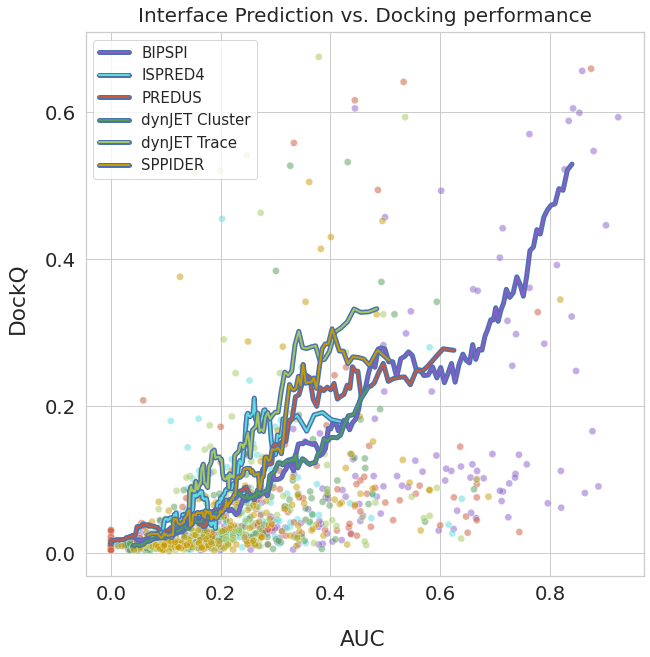

Spearman
Min nan Avg nan 	 BIP1
Min 0.811 Avg 0.789 	 BIP2
Min 0.567 Avg 0.523 	 ISP_SVM
Min nan Avg nan 	 ISP_CRF
Min 0.767 Avg 0.606 	 PRE
Min 0.742 Avg 0.58 	 JET_CL
Min 0.545 Avg 0.566 	 JET_TR
Min 0.667 Avg 0.594 	 SPP


In [10]:
sb.set_palette(palette=palette3)
data = {'Min':[], 'Avg':[], 'DockQ':[], 'Method':[]}
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

for tag in tags:
    maptag = tag + 'map'
    if tag in ['ISP_CRF', 'BIP1']: continue
    for pdb in codelist:
        if pdb in method_fail: continue
        if not pdb in dockqs[tag]: continue
        if not pdb in metricdic[maptag]: continue
        dockQ = dockqs[tag][pdb][0]
        if tag == 'PRE':
            data['Min'].append(min(metricdic[maptag][pdb]['PPVs'][:2]))
            data['Avg'].append(sum(metricdic[maptag][pdb]['PPVs'][:2])/2)
        else:
            data['Min'].append(min(metricdic[maptag][pdb]['PR-AUC'][:2]))
            data['Avg'].append(sum(metricdic[maptag][pdb]['PR-AUC'][:2])/2)
        data['DockQ'].append(dockQ)
        data['Method'].append(tag) 
   
sb.scatterplot(x='Min', y='DockQ', hue='Method', alpha=0.5, data=data, s=50, color=palette1[1], ax=axes)
#sb.scatterplot(x='Avg', y='DockQ', hue='Method', alpha=0.5, data=data, s=50, color=palette1[1], ax=axes)
axes.legend([],[], frameon=False)
#axes[1].legend([],[], frameon=False)
#axes[0].set_xlabel('')    
axes.set_xlabel('')
axes.set_ylabel('')
axes.set_xticks(np.arange(0,0.9,0.2))
axes.set_yticks(np.arange(0,0.9,0.2))
print ('Running avg. Spearman')
for tag in tags:
    dqlist = []
    minlist = []
    avglist = []
    maptag = tag + 'map'
    if tag in ['ISP_CRF', 'BIP1']: continue
    
    count = 0
    for pdb in codelist:
        if pdb in method_fail: continue
        if not pdb in dockqs[tag]: continue
        if not pdb in metricdic[maptag]: continue
        dockQ = max(dockqs[tag][pdb][:10])
        if tag == 'BIP2' and pdb == '1xt9': print (metricdic[maptag][pdb]['PR-AUC'])
        if tag == 'PRE':
            minlist.append([min(metricdic[maptag][pdb]['PPVs'][:2]), dockQ])
            avglist.append([sum(metricdic[maptag][pdb]['PPVs'][:2])/2, dockQ])
        else:
            minlist.append([min(metricdic[maptag][pdb]['PR-AUC'][:2]), dockQ])
            avglist.append([sum(metricdic[maptag][pdb]['PR-AUC'][:2])/2, dockQ])
        count += 1
    minlist = np.array(minlist)
    avglist = np.array(avglist)
    minlist = minlist[minlist[:,0].argsort()]
    avglist = avglist[avglist[:,0].argsort()]
    
    window = 20
    minDQ = []
    avgDQ = []
    minAUC = []
    avgAUC = []
    running = {'min':[], 'mindq':[],  
               'avg':[], 'avgdq':[]}
    for idx in range(len(minlist)):
        if len(minDQ) < window:
            minDQ.append(minlist[idx][1])
            minAUC.append(minlist[idx][0])
            avgDQ.append(avglist[idx][1])
            avgAUC.append(avglist[idx][0])
        else:
            minDQ = minDQ[1:]+[minlist[idx][1]]
            minAUC = minAUC[1:]+[minlist[idx][0]]
            avgDQ = avgDQ[1:]+[avglist[idx][1]]
            avgAUC = avgAUC[1:]+[avglist[idx][0]]
            
        if len(minDQ) == window:
            running['min'].append(sum(minAUC)/len(minAUC))
            running['mindq'].append(sum(minDQ)/len(minDQ))
            running['avg'].append(sum(avgAUC)/len(avgAUC))
            running['avgdq'].append(sum(avgDQ)/len(avgDQ))
            
    axes.plot(running['min'], running['mindq'], lw=2, label=name_refine[tag],
              path_effects=[pe.Stroke(linewidth=5, foreground='b'), pe.Normal()])
    #axes.plot(running['avg'], running['avgdq'], lw=2, label=name_refine[tag],
    #             path_effects=[pe.Stroke(linewidth=5, foreground='b'), pe.Normal()])
    print ('Min', round(spearmanr(running['min'], running['mindq'])[0],3), 
           'Avg', round(spearmanr(running['avg'], running['avgdq'])[0],3), '\t', tag)
axes.set_title('Interface Prediction vs. Docking performance', fontdict={'fontsize':20, 'verticalalignment': 'bottom'})
#axes[1].set_title('Average', fontdict={'fontsize':20, 'verticalalignment': 'bottom'})
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[:6], labels[:6], loc='upper left', markerscale=2, 
               fontsize=20, prop={'size':15})
        
plt.subplots_adjust(wspace=0.06)
fig.text(0.51, 0.05, 'AUC', ha='center', va='top')
fig.text(0.03, 0.51, 'DockQ', ha='center', va='center', rotation=90)

plt.show()
#add running average, all methods in one, add one with average score
data = pd.DataFrame(data)
print ('Spearman')
for tag in tags: 
    subdata = data.loc[data['Method']==tag]
    
    print ('Min', round(spearmanr(subdata['Min'], subdata['DockQ'])[0],3), 
           'Avg', round(spearmanr(subdata['Avg'], subdata['DockQ'])[0],3), '\t', tag)

    
    
fig.savefig(bsfolder+'pictures/DockQxAUC.png')

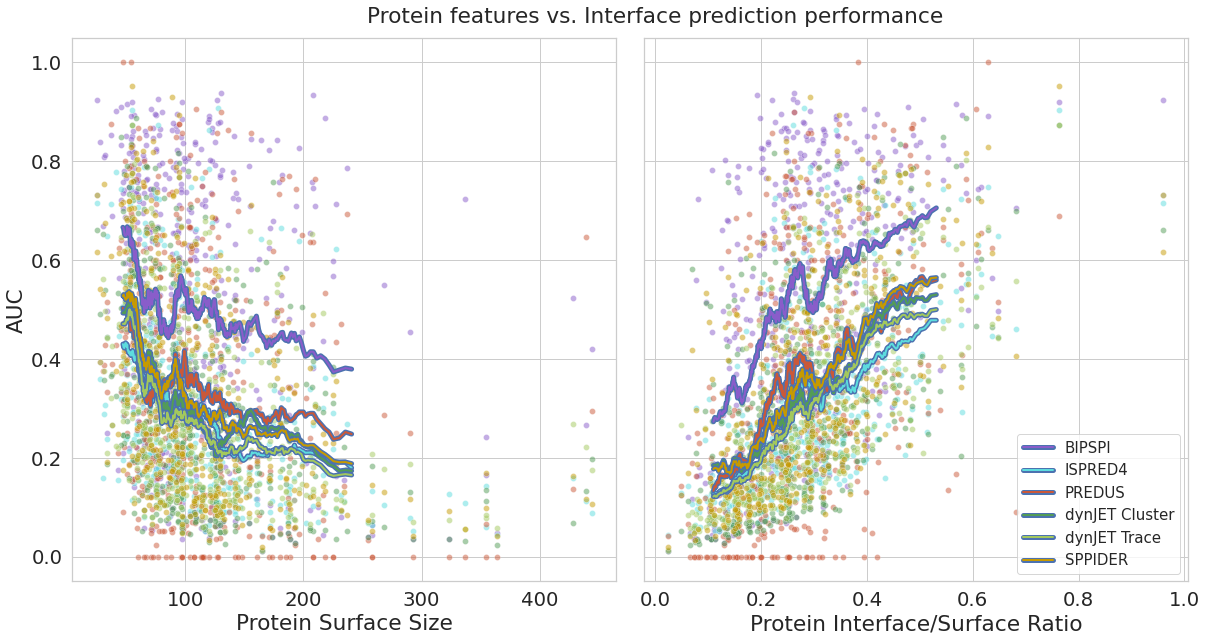

In [11]:
window = 50
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=True)
sets = {'BIP2':[], 'ISP_SVM':[], 'PRE':[], 'JET_CL':[], 'JET_TR':[], 'SPP':[]}

for tag in tags:
    arr = []
    data = {'Size':[], 'AUC':[]}
    if tag in ['ISP_CRF', 'BIP1']: continue
    if code not in dockqs[tag]: continue
    for code in codelist:
        data['Size'].append(surfaces[code][0])
        data['Size'].append(surfaces[code][1])
        if tag != 'PRE':
            arr.append([surfaces[code][0], metricdic[tag+'map'][code]['PR-AUC'][0]])
            arr.append([surfaces[code][1], metricdic[tag+'map'][code]['PR-AUC'][1]])
            data['AUC'].append(metricdic[tag+'map'][code]['PR-AUC'][0])
            data['AUC'].append(metricdic[tag+'map'][code]['PR-AUC'][1])
        else:
            arr.append([surfaces[code][0], metricdic[tag+'map'][code]['PPVs'][0]])
            arr.append([surfaces[code][1], metricdic[tag+'map'][code]['PPVs'][1]])
            data['AUC'].append(metricdic[tag+'map'][code]['PPVs'][0])
            data['AUC'].append(metricdic[tag+'map'][code]['PPVs'][1])

    arr = np.array(arr)
    arr = arr[arr[:,0].argsort()]

    LEN = []
    AUC = []
    running = {'LEN':[], 'AUC':[]}
    for idx in range(len(arr)):
        if len(LEN) < window:
            LEN.append(arr[idx][0])
            AUC.append(arr[idx][1])
        else:
            LEN = LEN[1:]+[arr[idx][0]]
            AUC = AUC[1:]+[arr[idx][1]]
            
        if len(LEN) == window:
            running['LEN'].append(sum(LEN)/len(LEN))
            running['AUC'].append(sum(AUC)/len(AUC))

    sb.scatterplot(x='Size', y='AUC', data=data, alpha=0.5, ax=axes[0])
    axes[0].plot(running['LEN'], running['AUC'], lw=2, label=name_refine[tag],
             path_effects=[pe.Stroke(linewidth=5, foreground='b'), pe.Normal()])
    #handles, labels = axes[0].get_legend_handles_labels()
    #axes[0].legend(handles[:6], labels[:6], loc='upper right', markerscale=2, 
    #            fontsize=20, prop={'size':15})
    axes[0].legend().set_visible(False)
axes[0].set_xlabel('Protein Surface Size')

sets = {'BIP2':[], 'ISP_SVM':[], 'PRE':[], 'JET_CL':[], 'JET_TR':[], 'SPP':[]}

for tag in tags:
    arr = []
    data = {'Size':[], 'AUC':[]}
    if tag in ['ISP_CRF', 'BIP1']: continue
    if code not in dockqs[tag]: continue
    for code in codelist:
        data['Size'].append(interfaces[code][0]/surfaces[code][0])
        data['Size'].append(interfaces[code][1]/surfaces[code][1])
        if tag != 'PRE':
            arr.append([interfaces[code][0]/surfaces[code][0], metricdic[tag+'map'][code]['PR-AUC'][0]])
            arr.append([interfaces[code][1]/surfaces[code][1], metricdic[tag+'map'][code]['PR-AUC'][1]])
            data['AUC'].append(metricdic[tag+'map'][code]['PR-AUC'][0])
            data['AUC'].append(metricdic[tag+'map'][code]['PR-AUC'][1])
        else:
            arr.append([interfaces[code][0]/surfaces[code][0], metricdic[tag+'map'][code]['PPVs'][0]])
            arr.append([interfaces[code][1]/surfaces[code][1], metricdic[tag+'map'][code]['PPVs'][1]])
            data['AUC'].append(metricdic[tag+'map'][code]['PPVs'][0])
            data['AUC'].append(metricdic[tag+'map'][code]['PPVs'][1])

    arr = np.array(arr)
    arr = arr[arr[:,0].argsort()]

    LEN = []
    AUC = []
    running = {'LEN':[], 'AUC':[]}
    for idx in range(len(arr)):
        if len(LEN) < window:
            LEN.append(arr[idx][0])
            AUC.append(arr[idx][1])
        else:
            LEN = LEN[1:]+[arr[idx][0]]
            AUC = AUC[1:]+[arr[idx][1]]
            
        if len(LEN) == window:
            running['LEN'].append(sum(LEN)/len(LEN))
            running['AUC'].append(sum(AUC)/len(AUC))

    sb.scatterplot(x='Size', y='AUC', data=data, alpha=0.5, ax=axes[1])
    axes[1].plot(running['LEN'], running['AUC'], lw=2, label=name_refine[tag],
             path_effects=[pe.Stroke(linewidth=5, foreground='b'), pe.Normal()])
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[:6], labels[:6], loc='lower right', markerscale=2, 
                   fontsize=20, prop={'size':15})
    axes[1].set_xlabel('Protein Interface/Surface Ratio')
    
plt.text(x=0, y=1.08, s='Protein features vs. Interface prediction performance', ha='center')
plt.subplots_adjust(wspace=0.05)
fig.savefig(bsfolder+'pictures/AUCxProt.png')


In [12]:
data = {}
file = open(bsfolder+'results/matrix.pickle', 'rb')
file = pickle.load(file)

for n in [12,13,15,16,17,18]:
    tag = postag[n]
    data[tag] = {'DockQ':[], 'Clust.DockQ':[]}
    for code in codelist:
        if code not in dockqs[tag]: continue
        for n1 in range(0,10):
            data[tag]['DockQ'].append(dockqs[tag][code][n1])
            data[tag]['Clust.DockQ'].append(sum(file[n][code][n1+1])/len(file[n][code][n1+1]))

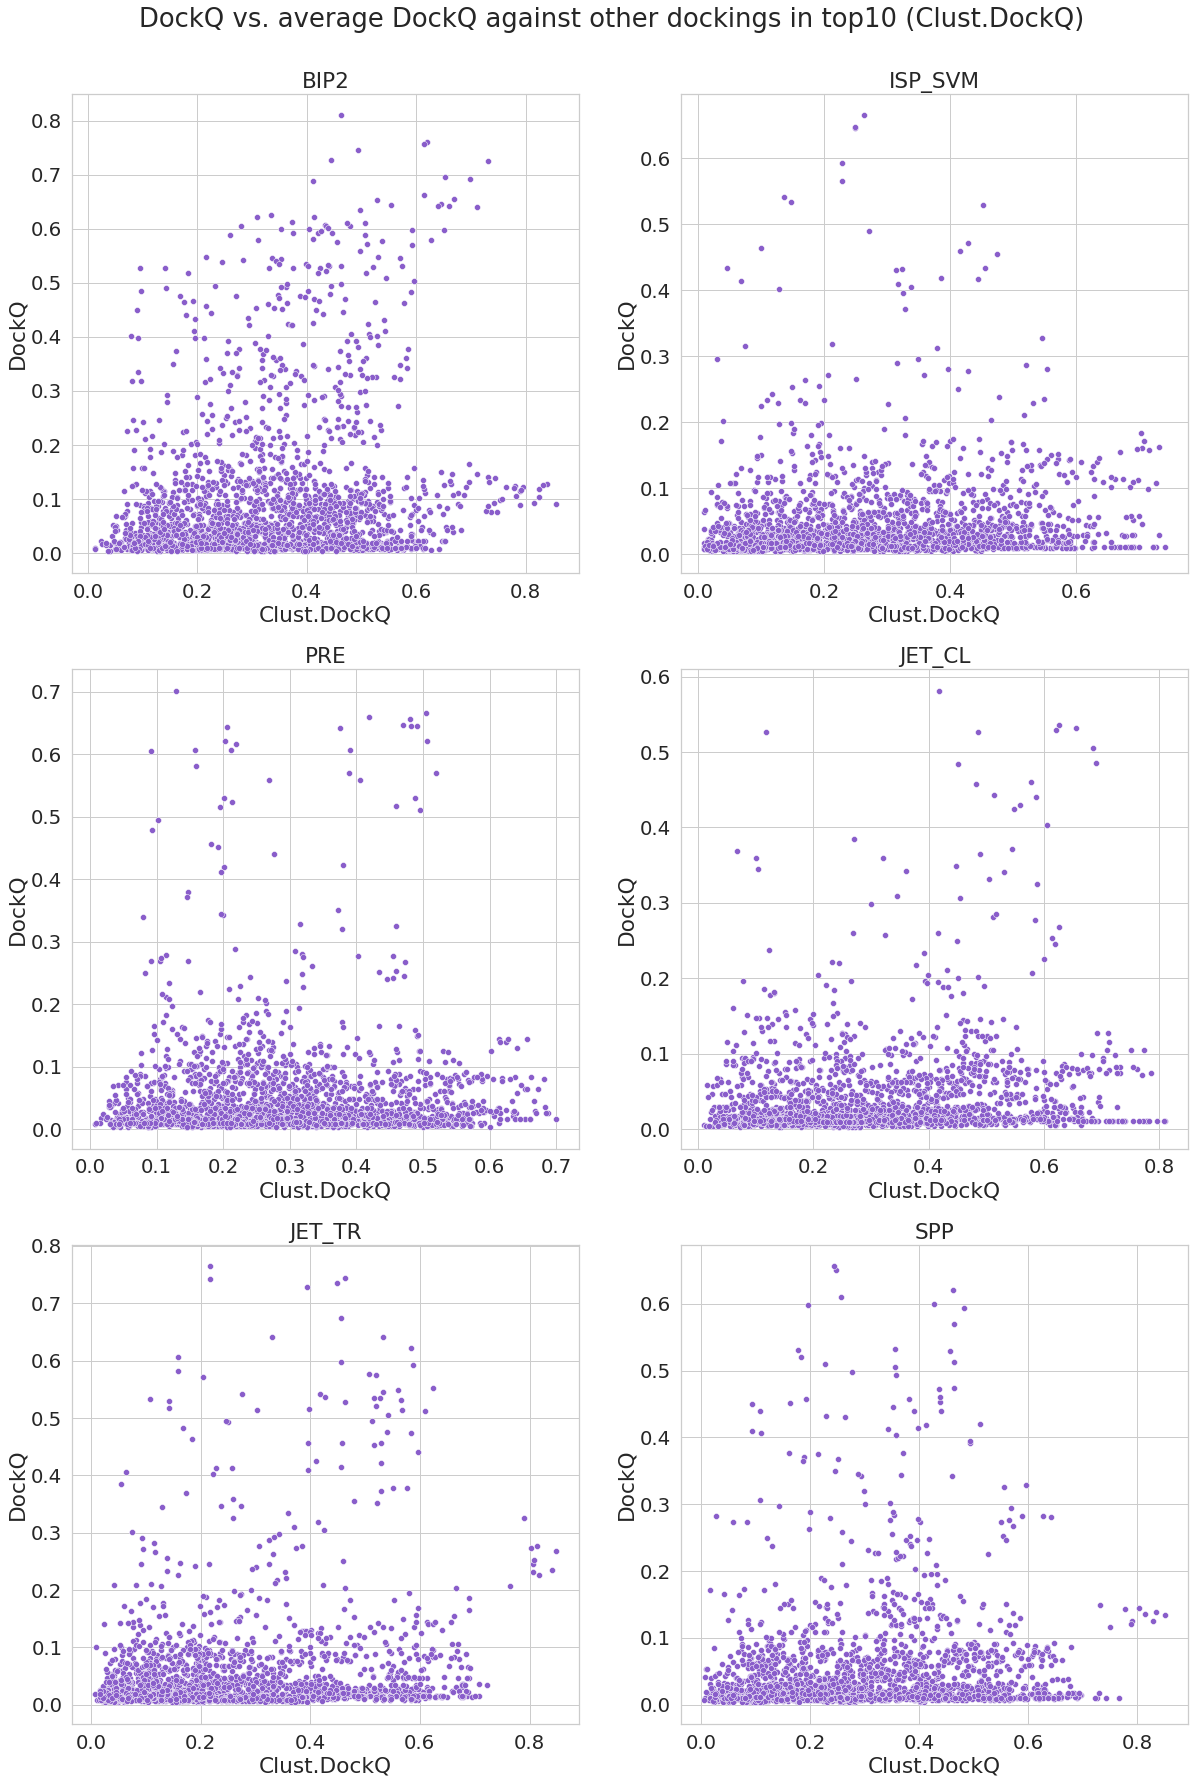

In [13]:
x = y = 0
fig, axes = plt.subplots(3, 2, figsize=(20, 30))
for tag in data:
    sb.scatterplot(x='Clust.DockQ', y='DockQ', data=data[tag], ax=axes[y][x])
    axes[y][x].set_title(tag)
    x += 1
    if x > 1: 
        x = 0
        y += 1
fig.suptitle('DockQ vs. average DockQ against other dockings in top10 (Clust.DockQ)', y=0.92)
fig.savefig(bsfolder+'pictures/cons.png')

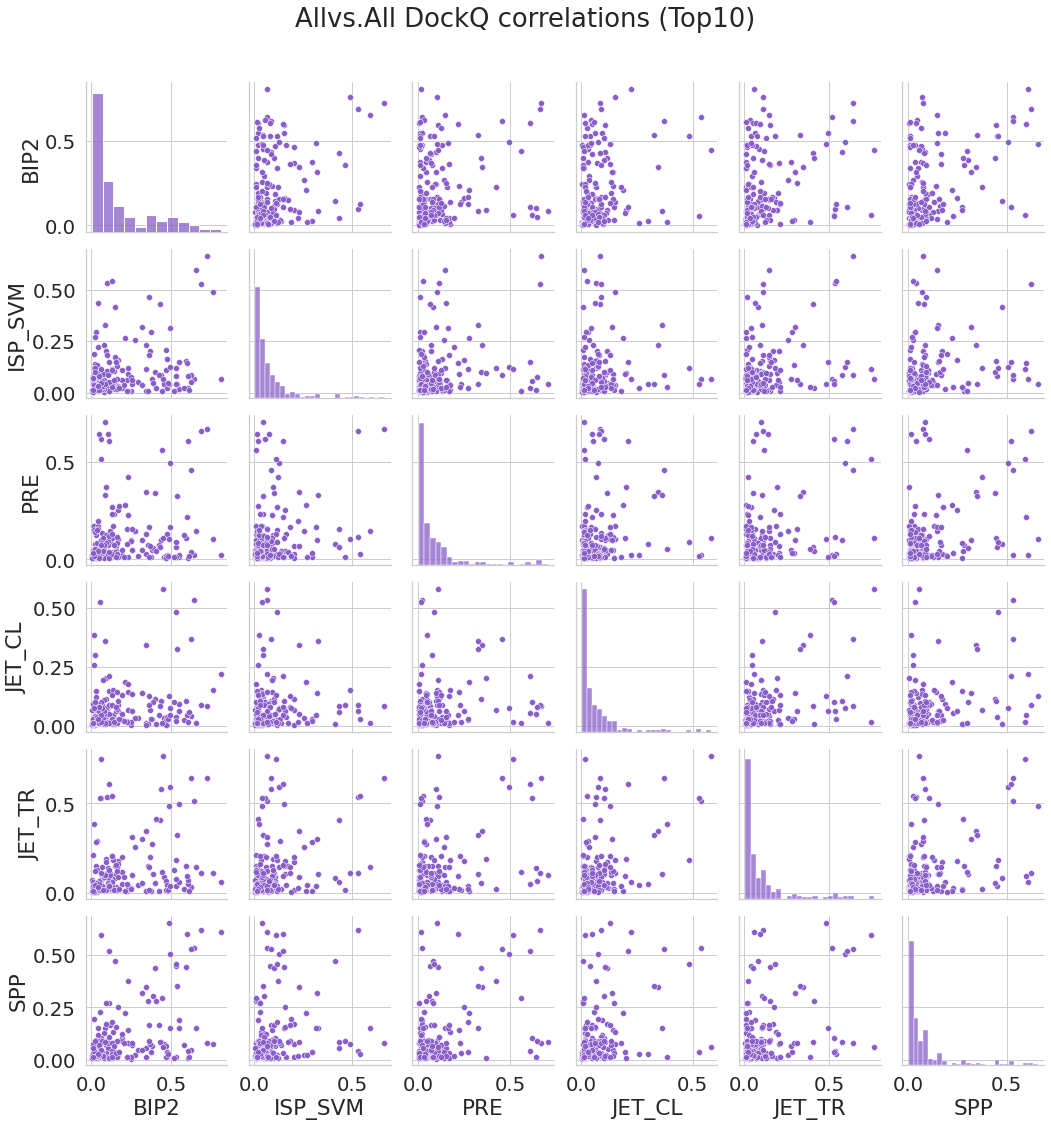

In [14]:
data = {}

for code in codelist:
    temp = {}
    for tag in tags:
        if tag in ['ISP_CRF', 'BIP1']: continue
        if tag not in data: data[tag] = []
        if code not in dockqs[tag]: break
        temp[tag] = max(dockqs[tag][code])
        #for dq in dockqs[tag][code]: temp[tag] = dq
    if len(temp) == 6:
        for tag in temp: data[tag].append(temp[tag])

data = pd.DataFrame(data)
fig = sb.pairplot(data)
fig.fig.suptitle('Allvs.All DockQ correlations (Top10)', y=1.05)
fig.savefig(bsfolder+'pictures/allcorr10.png')

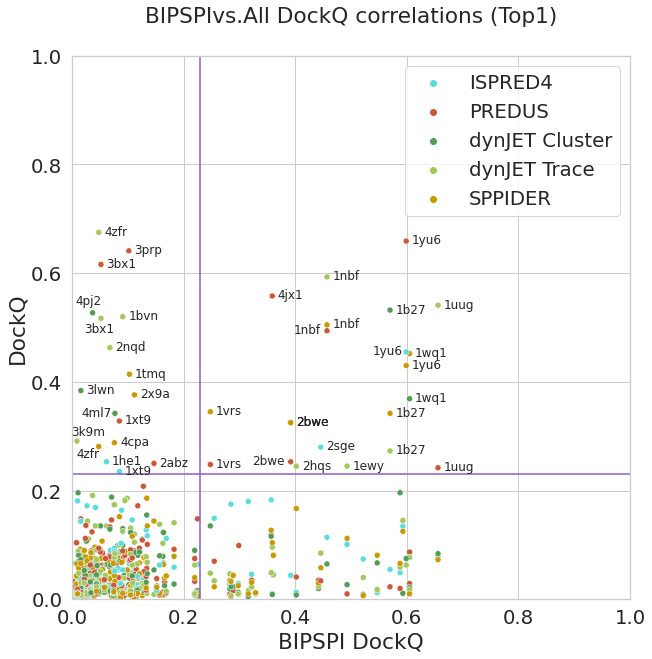

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
data = {'BIPSPI DockQ':[], 'DockQ':[], 'Method':[], 'Code':[]}
for code in codelist:
    for tag in tags:
        if tag in ['ISP_CRF', 'BIP1', 'BIP2']: continue
        if code in dockqs[tag]:
            data['BIPSPI DockQ'].append(dockqs['BIP2'][code][0])
            data['DockQ'].append(dockqs[tag][code][0])
            data['Method'].append(name_refine[tag])
            data['Code'].append(code)
            
data = pd.DataFrame(data)

sb.scatterplot(x='BIPSPI DockQ', y='DockQ', data=data, hue='Method', palette=['C1','C2','C3','C4','C5'], ax=axes)
for n, code in enumerate(data['Code']):
    if data['DockQ'][n] > 0.23:
        if data['Method'][n] == 'dynJET Trace' and code == '3k9m':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.01, data['DockQ'][n]+0.01))
        elif data['Method'][n] == 'dynJET Cluster' and code == '4pj2':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.03, data['DockQ'][n]+0.015))
        elif data['Method'][n] == 'dynJET Trace' and code == '3bx1':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.03, data['DockQ'][n]-0.025))
        elif data['Method'][n] == 'dynJET Cluster' and code == '4ml7':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.06, data['DockQ'][n]-0.005))
        elif data['Method'][n] == 'SPPIDER' and code == '4zfr':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.04, data['DockQ'][n]-0.02))
        elif data['Method'][n] == 'PREDUS' and code == '2bwe':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.07, data['DockQ'][n]-0.005))
        elif data['Method'][n] == 'PREDUS' and code == '1nbf':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.06, data['DockQ'][n]-0.005))
        elif data['Method'][n] == 'ISPRED4' and code == '1yu6':
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]-0.06, data['DockQ'][n]-0.005))
        else:
            axes.annotate(code, size=12,
                          xy=(data['BIPSPI DockQ'][n], data['DockQ'][n]), 
                          xytext=(data['BIPSPI DockQ'][n]+0.01, data['DockQ'][n]-0.005))
        
plt.hlines(0.23, 0, 1)
plt.vlines(0.23, 0, 1)
axes.set_xlim(0,1)
axes.set_ylim(0,1)
plt.legend(loc='upper right')
plt.title('BIPSPIvs.All DockQ correlations (Top1)', y=1.05)
fig.savefig(bsfolder+'pictures/allcorr1.png')